$$\require{mhchem}$$       

- Label the x/y axis of graphs (and legend if appropriate)
- Comment your code so we understand what you're doing
- 'print' your identified solutions / fitted constants with units

# Effectiveness factors (30 pt)

The following second-order gas-phase catalytic reaction is conducted in an isothermal fixed-bed reactor.
\begin{align*}
\ce{A->B}
\end{align*}
The volumetric rate constant inside the catalyst particle is 15.0 L/mol/s at 800 K.
The feed is 1,500 L/hr of pure A at 10.0 atm and 800 K.
Spherical catalyst pellets of radius 1.2 cm are used to pack the reactor.
The catalyst particles have a density of 0.9 g/cm$^3$.
The effective diffusivity of A inside the catalyst pellet is 2.06 $\times 10^{-4}$ cm$^2$/s.
There is no pressure drop.

####  Calculate the Thiele modulus at the inlet of the reactor. (6 pt)

In [208]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from pycse.PYCSE import odelay

In [220]:
k = 15 # L/mol/s at 800 K
nu = 1500 / 3600 # L/s
P = 10 * 101325 # Pa
T = 800 # K

r = 1.2e-2 # m
rho_cat = 0.9e3 # g/L
Da = 2.06e-4 / 1e4 # m^2/s

The Thele modulus calculated is in this form: $ \Phi = \sqrt{\displaystyle \frac{n+1}{2} \frac{k c_{As}^{n-1} a^2}{D_A} } $

In [221]:
R = 8.314 # J/mol/K
CA0 = P / R / T / 1e3 # mol / L
# a = r / 3

Phi0 = ((2 + 1) / 2 * k * CA0 * (1.2e-2 / 3) ** 2 / Da) ** 0.5

print('The Thiele modulus at the inlet of the reactor is {:1.2f}.'.format(Phi0))

The Thiele modulus at the inlet of the reactor is 51.60.


####  Calculate the reaction rate per gram of catalyst particle at the inlet of the reactor. Use the following modified form for the effective reaction rate: (4 pt)
\begin{equation}
r = -k\: c_{As}^n\frac{\eta}{\rho_{cat}}
\end{equation}

In [222]:
eta0 = 1 / np.tanh(3 * Phi0) - 1 / (3 * Phi0)

r = - k * CA0 ** 2 * eta0 / rho_cat

print('The reaction rate per gram of catalyst particle at the inlet of the reactor is {:1.2e} mol/L/s/(g_cat/L).'.format(r))
print('The effective factor at the inlet is {:1.2e}.'.format(eta0))

The reaction rate per gram of catalyst particle at the inlet of the reactor is -3.84e-04 mol/L/s/(g_cat/L).
The effective factor at the inlet is 9.94e-01.


#### Calculate the concentration profile of $A$ for a reactor with 50 kg of catalyst. Note that $C_A$ is varying, so the Thiele modulus and effectiveness factor will change as well. (15 pt)

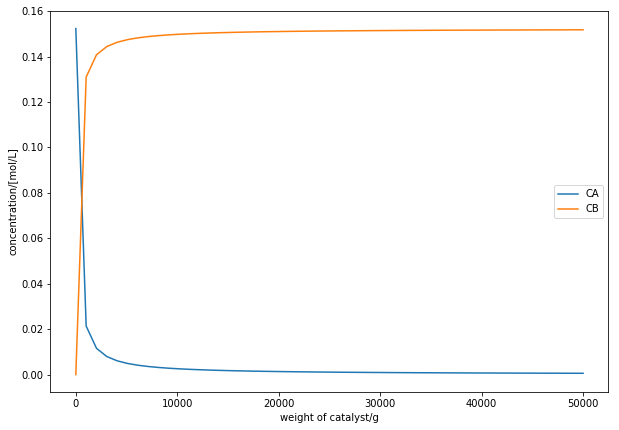

In [223]:
def Phi(CAS):
    return ((2 + 1) / 2 * k * CAS * (1.2e-2 / 3) ** 2 / Da) ** 0.5

def eta(CAS):
    return 1 / np.tanh(3 * Phi(CAS)) - 1 / (3 * Phi(CAS))

def PBR_1_3(F, W):
    FA, FB = F
    
    CA = FA / nu
    CB = FB / nu
    r = - k * CA ** 2 * eta(CA) / rho_cat
    
    return [r, -r]

Wspan = np.linspace(0, 50e3) # g
F0 = [CA0 * nu, 0]

sol_1_3 = odeint(PBR_1_3, F0, Wspan)

plt.figure(figsize = (10, 7))
plt.plot(Wspan, sol_1_3 / nu)
plt.xlabel('weight of catalyst/g')
plt.ylabel('concentration/[mol/L]')
plt.legend(['CA', 'CB'])
plt.show()

#### Calculate the mass of catalyst necessary to reach 85% conversion. (5 pt)

In [224]:
def event(F, W):
    FA, FB = F
    CB = FB / nu
    value = CB - 0.85 * CA0
    isterminal = True 
    direction = 0
    return value, isterminal, direction

Wspan = np.linspace(0, 50e3, 1000)
W, F, We, Fe, ie = odelay(PBR_1_3, F0, Wspan, [event])

print('The mass of catalyst necessary to reach 85% conversion is {:1.2f} g.'.format(We[0]))

The mass of catalyst necessary to reach 85% conversion is 941.55 g.


# Transient, non-isothermal reactor (50 pt)

The liquid phase reactions
\begin{align*}
\ce{A->B}\\
\ce{A->C}
\end{align*}
are each first order in the concentration of A.  The feed to a nonisothermal transient CSTR contains pure A at 45 $^{\circ}$C and 5 mol/L.  We want to operate this reactor such that the selectivity to B is greater than the selectivity to C.  The following parameters apply:

| Parameter       | Value                                    | Units   |
|-----------------|------------------------------------------|---------|
| $M_t$           | 93,200                                   | g/min   |
| $\Delta H_{r1}$ | -12,000                                  | cal/mol |
| $\Delta H_{r2}$ | -15,000                                  | cal/mol |
| V               | 1,000                                    | L       |
| $Q_f$           | 100                                      | L/min   |
| $C_{pf}$        | 0.22                                     | cal/g/K |
| $k_1$           | $3.16 \times 10^{14}\exp (-12,500 [K]/T)$ | 1/min   |
| $k_2$           | $2.52 \times 10^{9}\exp (-8,500 [K]/T) $  | 1/min   |

The CSTR has a cooling bath at 50 $^{\circ}$C and a $Ua$ of 100,000 cal/min/K.  The reactor initially starts at 45 $^{\circ}$C and C$_a$=C$_b$=C$_c$=0 M. The total mass in the reactor is $V M_t / Q_f$.

#### If you want to increase selectivity in the reactor ($C_B/C_C$), should you increase or decrease the temperature in the reactor? (5 pt)

The temperature in the reactor should be increased, because $\Delta H_{r2} < \Delta H_{r1} < 0$, so higher temperature would reduce the rate of reaction 2 more than reaction 1.

#### Calculate the  transient temperature and concentrations in this reactor.  You may assume the heats of reactions are constant w.r.t to temperature ( since Cpa=Cpb=Cpc, dCp=0) for the first 40 minutes. (30 pt)

\begin{equation}
    \frac{dT}{dt} = \frac{M_t C_{pf} (T_0 - T) - \Delta H_{rx} r V + \dot{Q}}{m_{total}C_{pf}}
\end{equation}

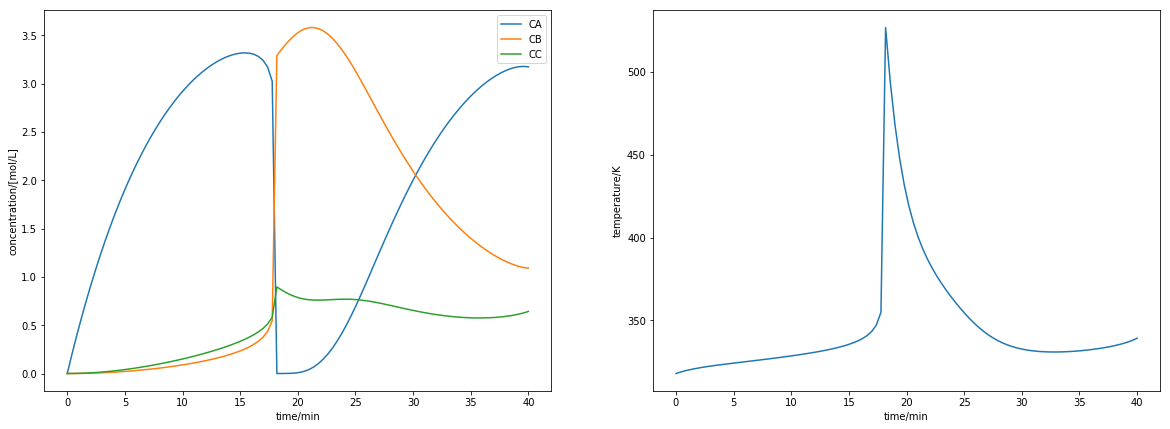

In [187]:
CAfeed = 5 # mol/L
Tfeed = 45 + 273 # K
T0 = 45 + 273 # K
Mt = 93200 # g/min
DH_R1 = -12000 # cal/mol
DH_R2 = -15000 # cal/mol
V = 1000 # L
nu = 100 # L/min
C_pf = 0.22 # cal/g/K

FT0 = CAfeed * nu # mol/min

def k1_(T):
    return 3.16e14 * np.exp(-12500 / T) # 1/min

def k2_(T):
    return 2.52e9 * np.exp(- 8500 / T) # 1/min

TA = 50 + 273 # K
Ua = 100000 # cal/min/K

m_total = V * Mt / Qf # g

tspan = np.linspace(0, 40, 100) # min

def CSTR_2_2(Y, t):
    
    CA, CB, CC, T = Y
    
    k1 = k1_(T)
    k2 = k2_(T)
    
    r1 = k1 * CA
    r2 = k2 * CA
    
    dCAdt = CAfeed * nu / V - CA * nu / V - r1 - r2
    dCBdt = - CB * nu / V + r1
    dCCdt = - CC * nu / V + r2
    
    Qdot = Ua * (TA - T) 
    dTdt = (Mt * C_pf * (Tfeed - T) - (DH_R1 * r1 + DH_R2 * r2) * V + Qdot) / (m_total * C_pf) # (V * (CA + CB + CC + 1e-7) * C_pf)

    return [dCAdt, dCBdt, dCCdt, dTdt]

Y0 = [0, 0, 0, T0]
sol_2_2 = odeint(CSTR_2_2, Y0, tspan)


plt.figure(figsize = (20, 7))
plt.subplot(1, 2, 1)
plt.plot(tspan, sol_2_2[:, 0:3])
plt.xlabel('time/min')
plt.ylabel('concentration/[mol/L]')
plt.legend(['CA', 'CB', 'CC'])

plt.subplot(1, 2, 2)
plt.plot(tspan, sol_2_2[:, 3])
plt.xlabel('time/min')
plt.ylabel('temperature/K')
# plt.legend(['CA', 'CB', 'CC'])
plt.show()

#### Calculate the cumulative selectivity of this reactor at 40 min, defined as $C_B/C_C$, as a function of the bath temperature, from 30 $^{\circ}$C to 60 $^{\circ}$C. (10 pt)

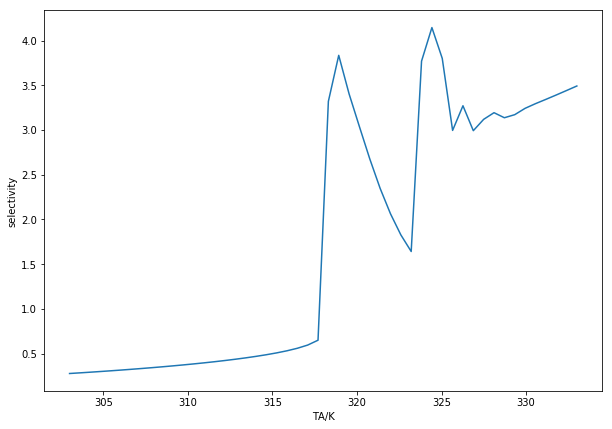

In [55]:
def CSTR_2_3(Y, t, TA):
    
    CA, CB, CC, T = Y
    
    k1 = k1_(T)
    k2 = k2_(T)
    
    r1 = k1 * CA
    r2 = k2 * CA
    
    dCAdt = CAfeed * nu / V - CA * nu / V - r1 - r2
    dCBdt = - CB * nu / V + r1
    dCCdt = - CC * nu / V + r2
    
    Qdot = Ua * (TA - T) 
    dTdt = (Mt * C_pf * (Tfeed - T) - (DH_R1 * r1 + DH_R2 * r2) * V + Qdot) / (m_total * C_pf) # (V * (CA + CB + CC + 1e-7) * C_pf)

    return [dCAdt, dCBdt, dCCdt, dTdt]

def obj_2_3(TA):
    Y0 = [0, 0, 0, T0]
    sol_tmp = odeint(CSTR_2_3, Y0, tspan, args = (TA,))
    CB = sol_tmp[-1, 1]
    CC = sol_tmp[-1, 2]
    
    S1 = CB / CC
    
    return S1

TAspan = np.linspace(30 + 273, 60 + 273)

sol_2_3 = []
for TA in TAspan:
     sol_2_3 += [obj_2_3(TA)]
plt.figure(figsize = (10, 7))
plt.plot(TAspan, sol_2_3)
plt.xlabel('TA/K')
plt.ylabel('selectivity')

plt.show()

#### Describe the profile and selectivity plots you made (a few sentences or bullets). Discuss any abnormalities you may see and why they appear. [5 pt]

There is a spike in the profile at around 20 min. This is because the rate is speeded up (because of the incrase of the temperature) then slowed down (because of the lack of reactant).
In selectivity plot there are 2 spikes at around 318 K and 325 K. This is because at these temparatures the concentrations and temperature are monotonially increasing and thus making the conversion big (318K) and there are 2 spikes in the profile at 325K.

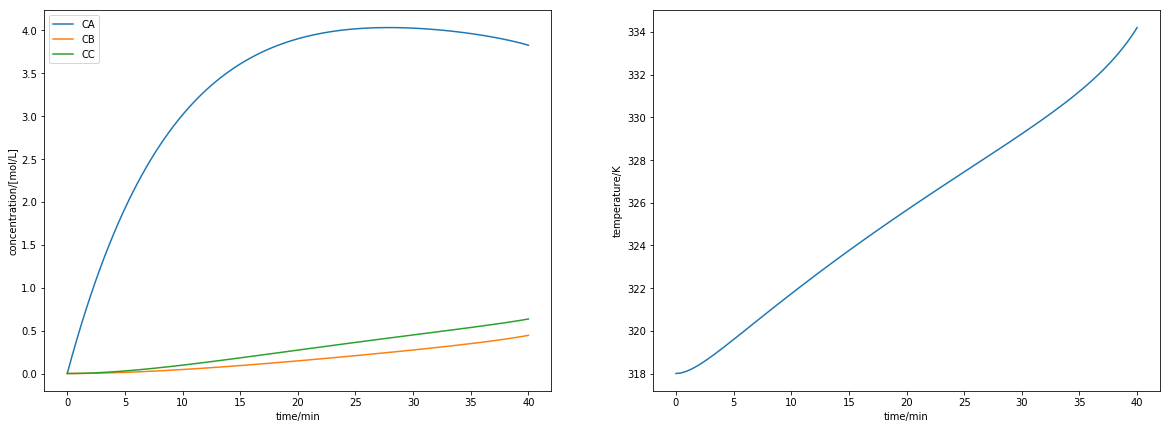

In [188]:
TA = 318 # K

def CSTR_2_2(Y, t):
    
    CA, CB, CC, T = Y
    
    k1 = k1_(T)
    k2 = k2_(T)
    
    r1 = k1 * CA
    r2 = k2 * CA
    
    dCAdt = CAfeed * nu / V - CA * nu / V - r1 - r2
    dCBdt = - CB * nu / V + r1
    dCCdt = - CC * nu / V + r2
    
    Qdot = Ua * (TA - T) 
    dTdt = (Mt * C_pf * (Tfeed - T) - (DH_R1 * r1 + DH_R2 * r2) * V + Qdot) / (m_total * C_pf) # (V * (CA + CB + CC + 1e-7) * C_pf)

    return [dCAdt, dCBdt, dCCdt, dTdt]

Y0 = [0, 0, 0, T0]
sol_2_2 = odeint(CSTR_2_2, Y0, tspan)


plt.figure(figsize = (20, 7))
plt.subplot(1, 2, 1)
plt.plot(tspan, sol_2_2[:, 0:3])
plt.xlabel('time/min')
plt.ylabel('concentration/[mol/L]')
plt.legend(['CA', 'CB', 'CC'])

plt.subplot(1, 2, 2)
plt.plot(tspan, sol_2_2[:, 3])
plt.xlabel('time/min')
plt.ylabel('temperature/K')
# plt.legend(['CA', 'CB', 'CC'])
plt.show()

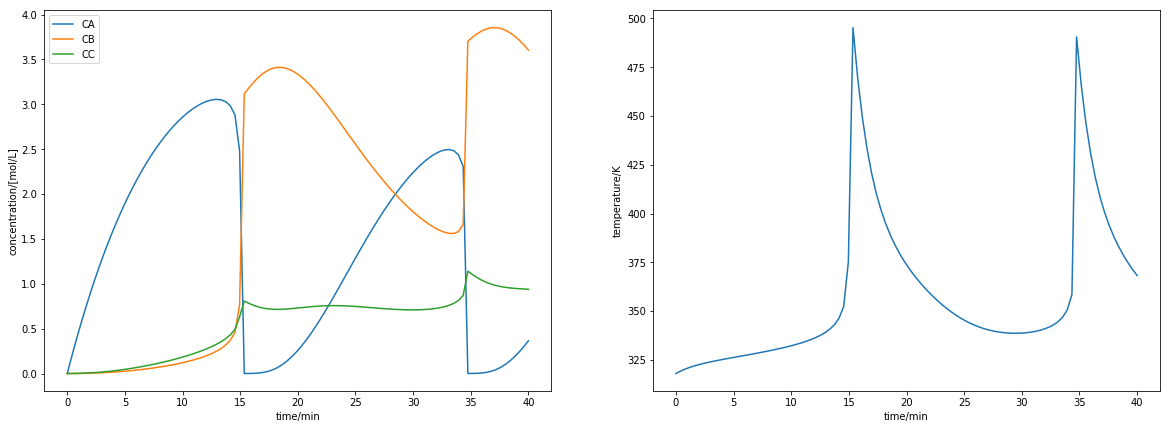

In [189]:
TA = 325 # K

def CSTR_2_2(Y, t):
    
    CA, CB, CC, T = Y
    
    k1 = k1_(T)
    k2 = k2_(T)
    
    r1 = k1 * CA
    r2 = k2 * CA
    
    dCAdt = CAfeed * nu / V - CA * nu / V - r1 - r2
    dCBdt = - CB * nu / V + r1
    dCCdt = - CC * nu / V + r2
    
    Qdot = Ua * (TA - T) 
    dTdt = (Mt * C_pf * (Tfeed - T) - (DH_R1 * r1 + DH_R2 * r2) * V + Qdot) / (m_total * C_pf) # (V * (CA + CB + CC + 1e-7) * C_pf)

    return [dCAdt, dCBdt, dCCdt, dTdt]

Y0 = [0, 0, 0, T0]
sol_2_2 = odeint(CSTR_2_2, Y0, tspan)


plt.figure(figsize = (20, 7))
plt.subplot(1, 2, 1)
plt.plot(tspan, sol_2_2[:, 0:3])
plt.xlabel('time/min')
plt.ylabel('concentration/[mol/L]')
plt.legend(['CA', 'CB', 'CC'])

plt.subplot(1, 2, 2)
plt.plot(tspan, sol_2_2[:, 3])
plt.xlabel('time/min')
plt.ylabel('temperature/K')
# plt.legend(['CA', 'CB', 'CC'])
plt.show()

# Short answers (explain with 1-2 sentences)

#### A 5-L adiabatic, catalytic PFR has a conversion of 55% for the reaction A(g) $\rightarrow$ B(g). The inlet flow rate was cut in half, but the conversion only increased to 56%. Of the three following explanations, which one(s) may explain this phenomenon? (5 pt)
1. reaction is limited by mass transfer	
2. reaction is equilibrium limited	
3. the decrease in velocity due to the increase in moles limits the conversion	

1 & 2.

cut flowrate in half will reduce the rate of mass transfer. Also if the reactoin is equilibrium limited, then cut flowrate in half will not help incrase the conversion.

In PFR, the velocity doesn't affect the final conversion, so 3 is out.

#### The concentration of A vs. distance in a PFR is shown for the first-order, exothermic reaction A $\rightarrow$ B. One curve represents an isothermal reactor, and the other an adiabatic reactor. Which statement is correct? (5 pt)
- 1 is adiabatic, 2 is isothermal	
- 1 is isothermal, 2 is adiabatic	
- Either could be adiabatic or isothermal	

![img](./20110902212632130d3e0582858752caea2af4d16c43da.gif)


1 is adiabatic, 2 is isothermal.

Since the reaction is exothermic, then if it's in an adiabatic reactor, the temperature will increase, thus speeding up the rate of reaction.

#### At a fixed O$_2$ pressure for the reaction:  (5 pt)

$\ce{CO + 1/2O2 -> CO2}$

the CO pressure increased from zero to a large number. If the reaction follows the Langmuir-Hinshelwood mechanism, what happens to the rate of reaction?
- goes through a maximum	
- goes through a minimum	
- increases slowly at first, then more rapidly	
- increases quickly at first, then more slowly	

goes through a maximum. Because when the pressure of CO is high, then the reaction is limited by the number of site and the pressure of O2.

#### A plot of rate versus distance along an adiabatic PFR for a 1st-order reaction is shown below (original). Which curve (A,B,C, D) will the plot look like if the feed temperature were increased? (5 pt)
![img](./2011090310020582250ee1b17678c159deb817f8252880.gif)


A. because of the higher feed temperature, the initial point should be higher. Also, higher rate means the reactant will be consumed out faster than before.